# Rigorous Thermodynamic Decomposition of NaCl's Effects on the Solubility of Polyethylene Glycol

Stefan Hervø-Hansen<sup>a</sup> and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 3: Analysis

### Introduction
Here we aim to provide a detailed thermodynamic analysis of how NaCl influence the solvation of polyethylene glycol (PEG). By utilizing molecular dynamics simulations, we can gain atomic insight into the mechanism which underpins the change in excess chemical potential of PEG with the addition of NaCl. Understanding these effects is crucial for applications in biochemistry and materials science, where PEG and its derivatives are widely used. The following sections detail the methods and materials employed in our simulations and analyses.

### Methods & Materials
Molecular dynamics simulations were conducted using the OpenMM (8.0)[<sup>1</sup>](#fn1) software package. The details of these simulations can be found in the [Part 1 Jupyter notebook](Simulations.ipynb). For the simulation of PEG, a CHARMM-derived force field (C35r) was utilized, which has previously been shown to reproduce the hydrodynamic radii and shape anisotropy of PEG[<sup>2</sup>](#fn2). The PEG force field was combined with the SPC/E force field for water[<sup>3</sup>](#fn3) and optimized ion parameters for sodium chloride[<sup>4</sup>](#fn4).

The isothermal-isobaric ensemble was sampled using a combination of a "Middle" discretization Langevin leap-frog integrator[<sup>5,</sup>](#fn5)[<sup>6</sup>](#fn6) and a Monte Carlo barostat[<sup>7,</sup>](#fn7)[<sup>8</sup>](#fn8). The trajectories were analyzed using MDTraj[<sup>9</sup>](#fn9) for structural properties, while ERmod[<sup>10</sup>](#fn10) was used for the calculation of solvation free energies. The calculation of solvation free energy can be found in the [Part 2 Jupyter notebook](ERmod.ipynb) and the analysis of data can be found in [Part 3 Jupyter notebook](Analysis.ipynb)

### References
1. <span id="fn1"> P. Eastman, et al., OpenMM 8: Molecular Dynamics Simulation with Machine Learning Potentials. J. Phys. Chem. B 128, 109–116 (2023). </span><br>
2. <span id="fn2"> H. Lee, R. M. Venable, A. D. MacKerell Jr., R. W. Pastor, Molecular Dynamics Studies of Polyethylene Oxide and Polyethylene Glycol: Hydrodynamic Radius and Shape Anisotropy. Biophysical Journal 95, 1590–1599 (2008). </span><br>
3. <span id="fn3"> H. J. C. Berendsen, J. R. Grigera, T. P. Straatsma, The missing term in effective pair potentials. J. Phys. Chem. 91, 6269–6271 (1987). </span><br>
4. <span id="fn4"> J. Heyda, J. C. Vincent, D. J. Tobias, J. Dzubiella, P. Jungwirth, Ion Specificity at the Peptide Bond: Molecular Dynamics Simulations of N-Methylacetamide in Aqueous Salt Solutions. J. Phys. Chem. B 114, 1213–1220 (2009). </span><br>
5. <span id="fn5"> B. Leimkuhler, C. Matthews, Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proc. R. Soc. A. 472, 20160138 (2016). </span><br>
6. <span id="fn6"> Z. Zhang, X. Liu, K. Yan, M. E. Tuckerman, J. Liu, Unified Efficient Thermostat Scheme for the Canonical Ensemble with Holonomic or Isokinetic Constraints via Molecular Dynamics. J. Phys. Chem. A 123, 6056–6079 (2019). </span><br>
7. <span id="fn7"> K.-H. Chow, D. M. Ferguson, Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91, 283–289 (1995). </span><br>
8. <span id="fn8"> J. Åqvist, P. Wennerström, M. Nervall, S. Bjelic, B. O. Brandsdal, Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384, 288–294 (2004). </span><br>
9. <span id="fn9"> R. T. McGibbon, et al., MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109, 1528–1532 (2015). </span><br>
10. <span id="fn10"> S. Sakuraba, N. Matubayasi, Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. J. Comput. Chem. 35, 1592–1608 (2014). </span><br>

## Import of Python Modules & Auxiliary Functions

In [1]:
#Notebook dependent libs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import re
import scipy.optimize as optimize
import scipy.ndimage as ndimage
from uncertainties import unumpy
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from multiprocessing import Pool

from Auxiliary import fessa
plt.set_cmap('fessa')

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"]) 

# Physical constants & useful conversions
kcal_to_kT = 1.688 # Assuming 298.15 K
Na = 6.02214076e23 # Avogadro constant [mol]
liter_to_cubeangstrom = 1e27
nm3_to_l = 1e-24


homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/group1/z44785r/PEO-Solubility


<Figure size 640x480 with 0 Axes>

In [2]:
def get_2D_PMF(xall, yall, weights=None, nbins=50, avoid_zero_count=True, minener_zero=True, kT=1.0, ranges=None):
    """Free energy plot given 2D scattered data.
Builds a 2D-histogram of the given data points and plots -log(p) where p is
the probability computed from the histogram count.
Parameters
----------
xall : ndarray(T)
    sample x-coordinates
yall : ndarray(T)
    sample y-coordinates
weights : ndarray(T), default = None
    sample weights. By default all samples have the same weight
nbins : int, default=100
    number of histogram bins used in each dimension
avoid_zero_count : bool, default=True
    avoid zero counts by lifting all histogram elements to the minimum value
    before computing the free energy. If False, zero histogram counts will
    yield NaNs in the free energy which and thus regions that are not plotted.
minener_zero : bool, default=True
    Shifts the energy minimum to zero. If false, will not shift at all.
kT : float, default=1.0
    The value of kT in the desired energy unit. By default, will compute
    energies in kT (setting 1.0). If you want to measure the energy in
    kJ/mol at 298 K, use kT=2.479 and change the cbar_label accordingly.
ranges : tuple
    The extend the 2d histogram should be compute. The tuple should 
    have the form ((xmin, xmax), (ymin, ymax)).
Returns
-------
(x,y,F)
"""
    # histogram
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights, range=ranges)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT * np.log(z)
    if minener_zero:
        F -= np.min(F)

    return (x,y,F.T)

### Simulation settings

In [3]:
states = { # State of simulations, (outFreq is steps per frame)
          'conf':{'Nsteps': 500000000, 'OutFreq': 1000}, # 1000 nanoseconds, 500.000 frames
          'sol': {'Nsteps': 125000000, 'OutFreq':  500}, #  250 nanoseconds, 250.000 frames
          'ref': {'Nsteps':  50000000, 'OutFreq':  500}, #  100 nanoseconds, 100.000 frames
         }

nmers = [36] # PEG polymer length
Nparticles = {       # Number of PEG and water molecules. Salt is calculated based on concentration input
    'PEG': 1,
    'Water': 10000,
}
NConfs = 100

# Approximate concentrations of salt (in Molar) under which the structual sampling is conducted.
salt_reference_concentrations = { # P1 and P2 are the perturbations that will be added to the salt concentration
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

salts = { # Types of salt added to the simulations.
         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl' }
}
Tbl_concentrations = {
   0.00: {'P0':   0, 'P1': 368, 'P2': 792},
   2.00: {'P0': 368, 'P1':   0, 'P2': 792},
   4.00: {'P0': 792, 'P1':   0, 'P2': 368},
}

GENERATE_ERMOD = True # Conduct ERmod analysis

## Structural Analysis
### Loading the trajectories

In [4]:
%cd -q $homedir
trajs = []

for conc in [0.00, 2.00, 4.00]:
    c = '{0:.2f}'.format(conc)
    traj = md.load_xtc('Simulations/PEG36mer/NaCl/{c}/Solute/trajectory_dry.xtc'.format(c=c),
                       top='Simulations/PEG36mer/NaCl/{c}/Solute/PEG_36_NaCl_{c}.pdb'.format(c=c))
    trajs.append(traj)

/home/z44785r/miniconda3/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


### Polymer relevant properties: radius of gyration, end-to-end distance, and solvent accessible surface area

NaCl	<Rg> (nm)		<End-to-end distance> (nm)	<SASA> (nm²)
0 M	1.2355314517820482	2.6414547			27.688349
2 M	1.0609704809299654	2.2999148			24.27089
4 M	0.9602997513385614	2.076825			22.126816


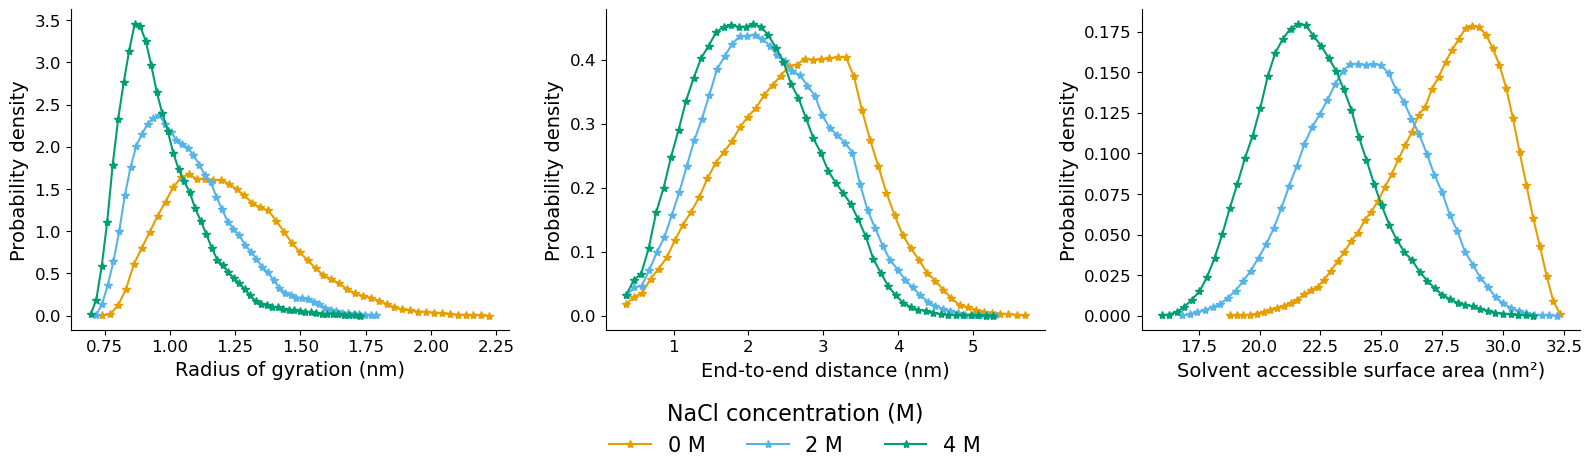

In [6]:
%cd -q $homedir
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

# If data is pre-computed use them, otherwise generate and save the data onto desk.
USE_PRECOMPUTED_DATA = True

labels = ['0 M', '2 M', '4 M']

print('NaCl\t<Rg> (nm)\t\t<End-to-end distance> (nm)\t<SASA> (nm²)')
for i, traj in enumerate(trajs):
    PEG_atoms = traj.topology.select('(resname PGH) or (resname PGM) or (resname PGT)')
    traj_PEG = traj.atom_slice(PEG_atoms)
    
    # ANALYSIS #
    # Radius of gyration
    if USE_PRECOMPUTED_DATA:
        rg = np.load('{}/Data/Rg_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:    
        rg = md.compute_rg(traj_PEG)
        np.save('{}/Data/Rg_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), rg)
    y,edges = np.histogram(rg, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[0].plot(centers,y,'-*', label=labels[i])
   
    # End-to-end distance
    if USE_PRECOMPUTED_DATA:
        end_to_end_distances = np.load('{}/Data/end-to-end_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:
        pairs = traj.topology.select_pairs('(resname PGH) and (name C1)', '(resname PGT) and (name C3)')
        end_to_end_distances = md.compute_distances(traj, pairs)
        np.save('{}/Data/end-to-end_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), end_to_end_distances)
    y,edges = np.histogram(end_to_end_distances, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[1].plot(centers,y,'-*', label=labels[i])
    
    # Solvent accessible surface area (SASA)
    if USE_PRECOMPUTED_DATA:
        SASAs = np.load('{}/Data/SASA_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]))
    else:
        SASAs = md.shrake_rupley(traj_PEG, mode='residue').sum(axis=1)
        np.save('{}/Data/SASA_PEG36_NaCl_{:.2f}.npy'.format(homedir,list(salt_reference_concentrations.keys())[i]), SASAs)
    y,edges = np.histogram(SASAs, bins=50, density=True)
    centers = 0.5*(edges[1:]+ edges[:-1])
    axes[2].plot(centers,y,'-*', label=labels[i])
    
    # Print mean values
    print(labels[i]+'\t'+str(rg.mean())+'\t'+str(end_to_end_distances.mean())+'\t\t\t'+str(SASAs.mean()))

xlabels = ['Radius of gyration (nm)', 'End-to-end distance (nm)', 'Solvent accessible surface area (nm²)']
for i, ax in enumerate(axes):
    ax.set_ylabel('Probability density', fontsize=14)
    ax.set_xlabel(xlabels[i], fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(i, []) for i in zip(*lines_labels)]
    
fig.legend(lines[0:3], labels[0:3], loc = 'lower center', ncol=8, fontsize=15, title='NaCl concentration (M)',
           title_fontsize=16, bbox_to_anchor=(0.5, -0.2), frameon=False)

fig.tight_layout()
fig.savefig('Figures/polymer_properties.pdf', bbox_inches='tight')